In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/28.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/31.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/Moderate

In [3]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-08-12 10:00:32.016717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 10:00:32.016945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 10:00:32.192816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 95.47it/s]


image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented

[6400 rows x 2 columns]

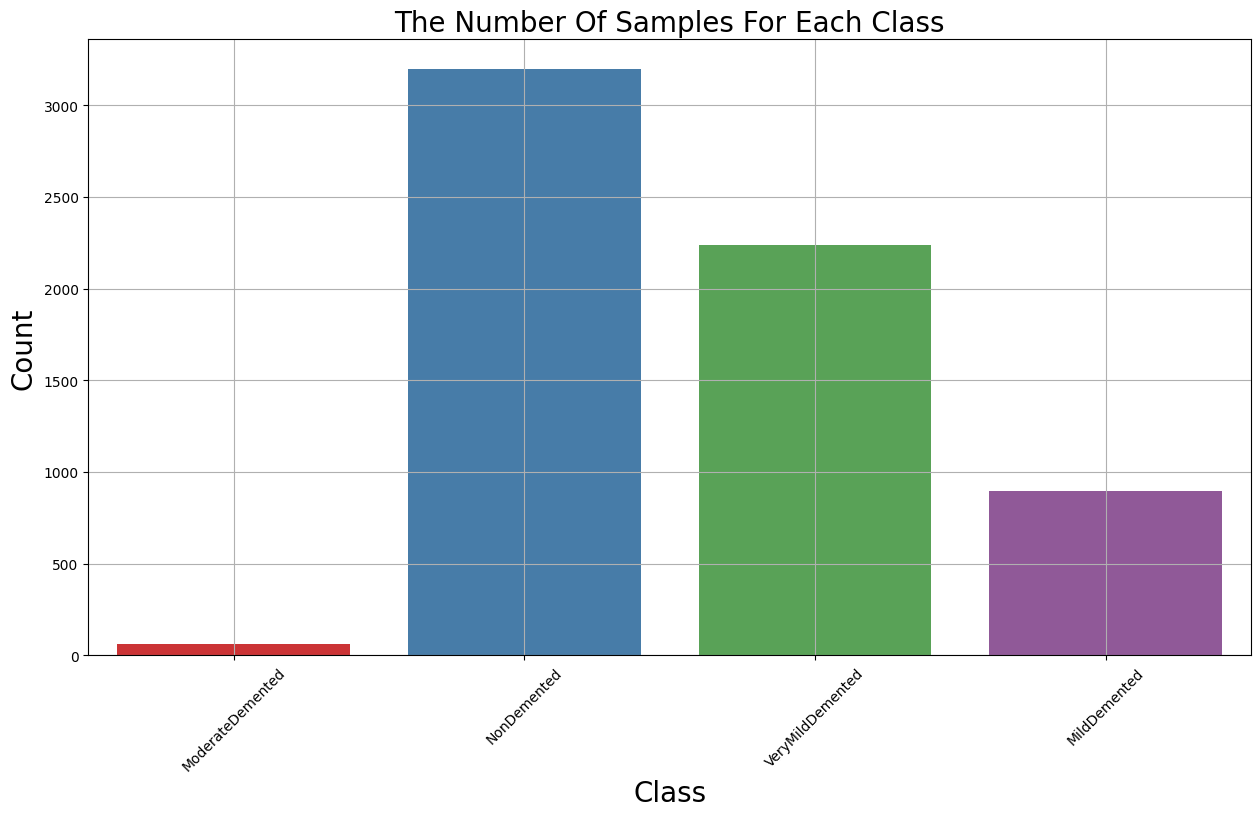

In [6]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [8]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [9]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

Found 6400 validated image filenames belonging to 4 classes.


In [10]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [11]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


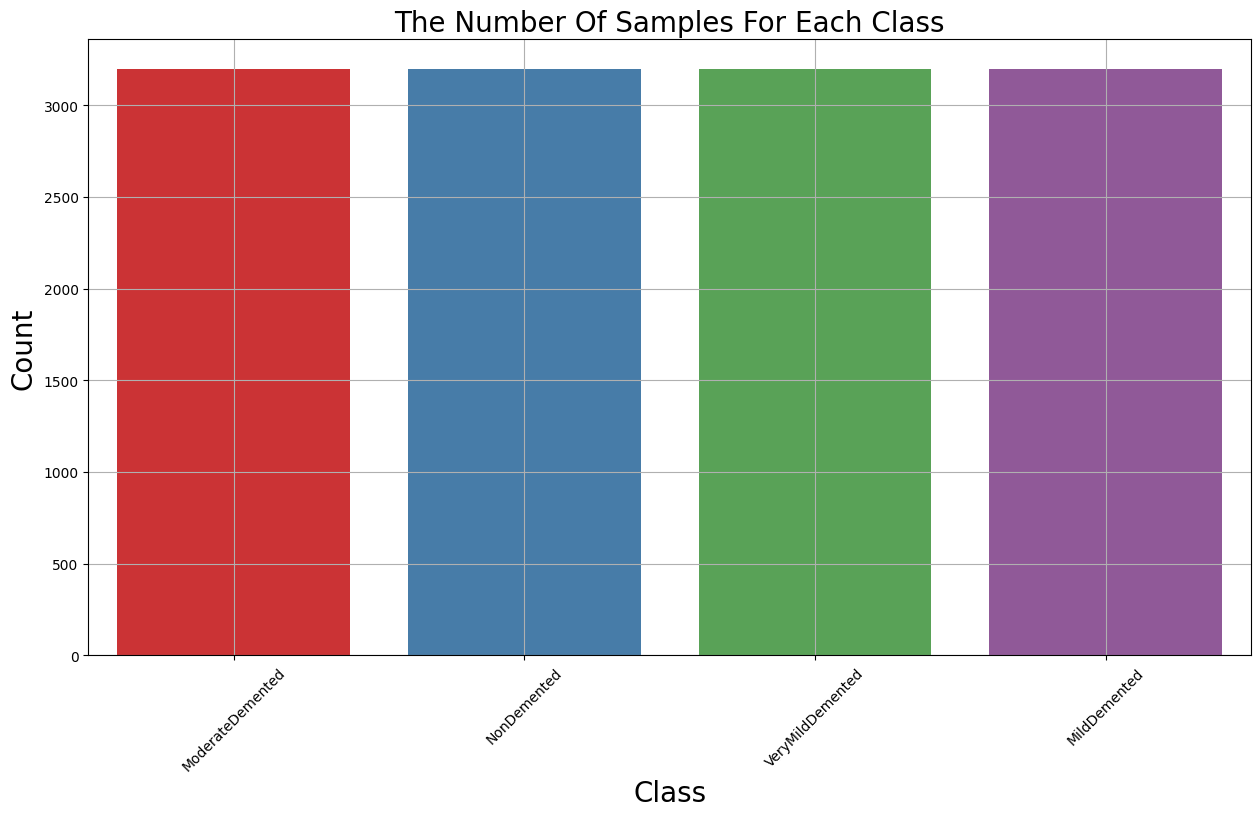

In [12]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [13]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [37]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(256,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 88, 88, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 655,684 (2.50 MB)

 Trainable params: 655,684 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

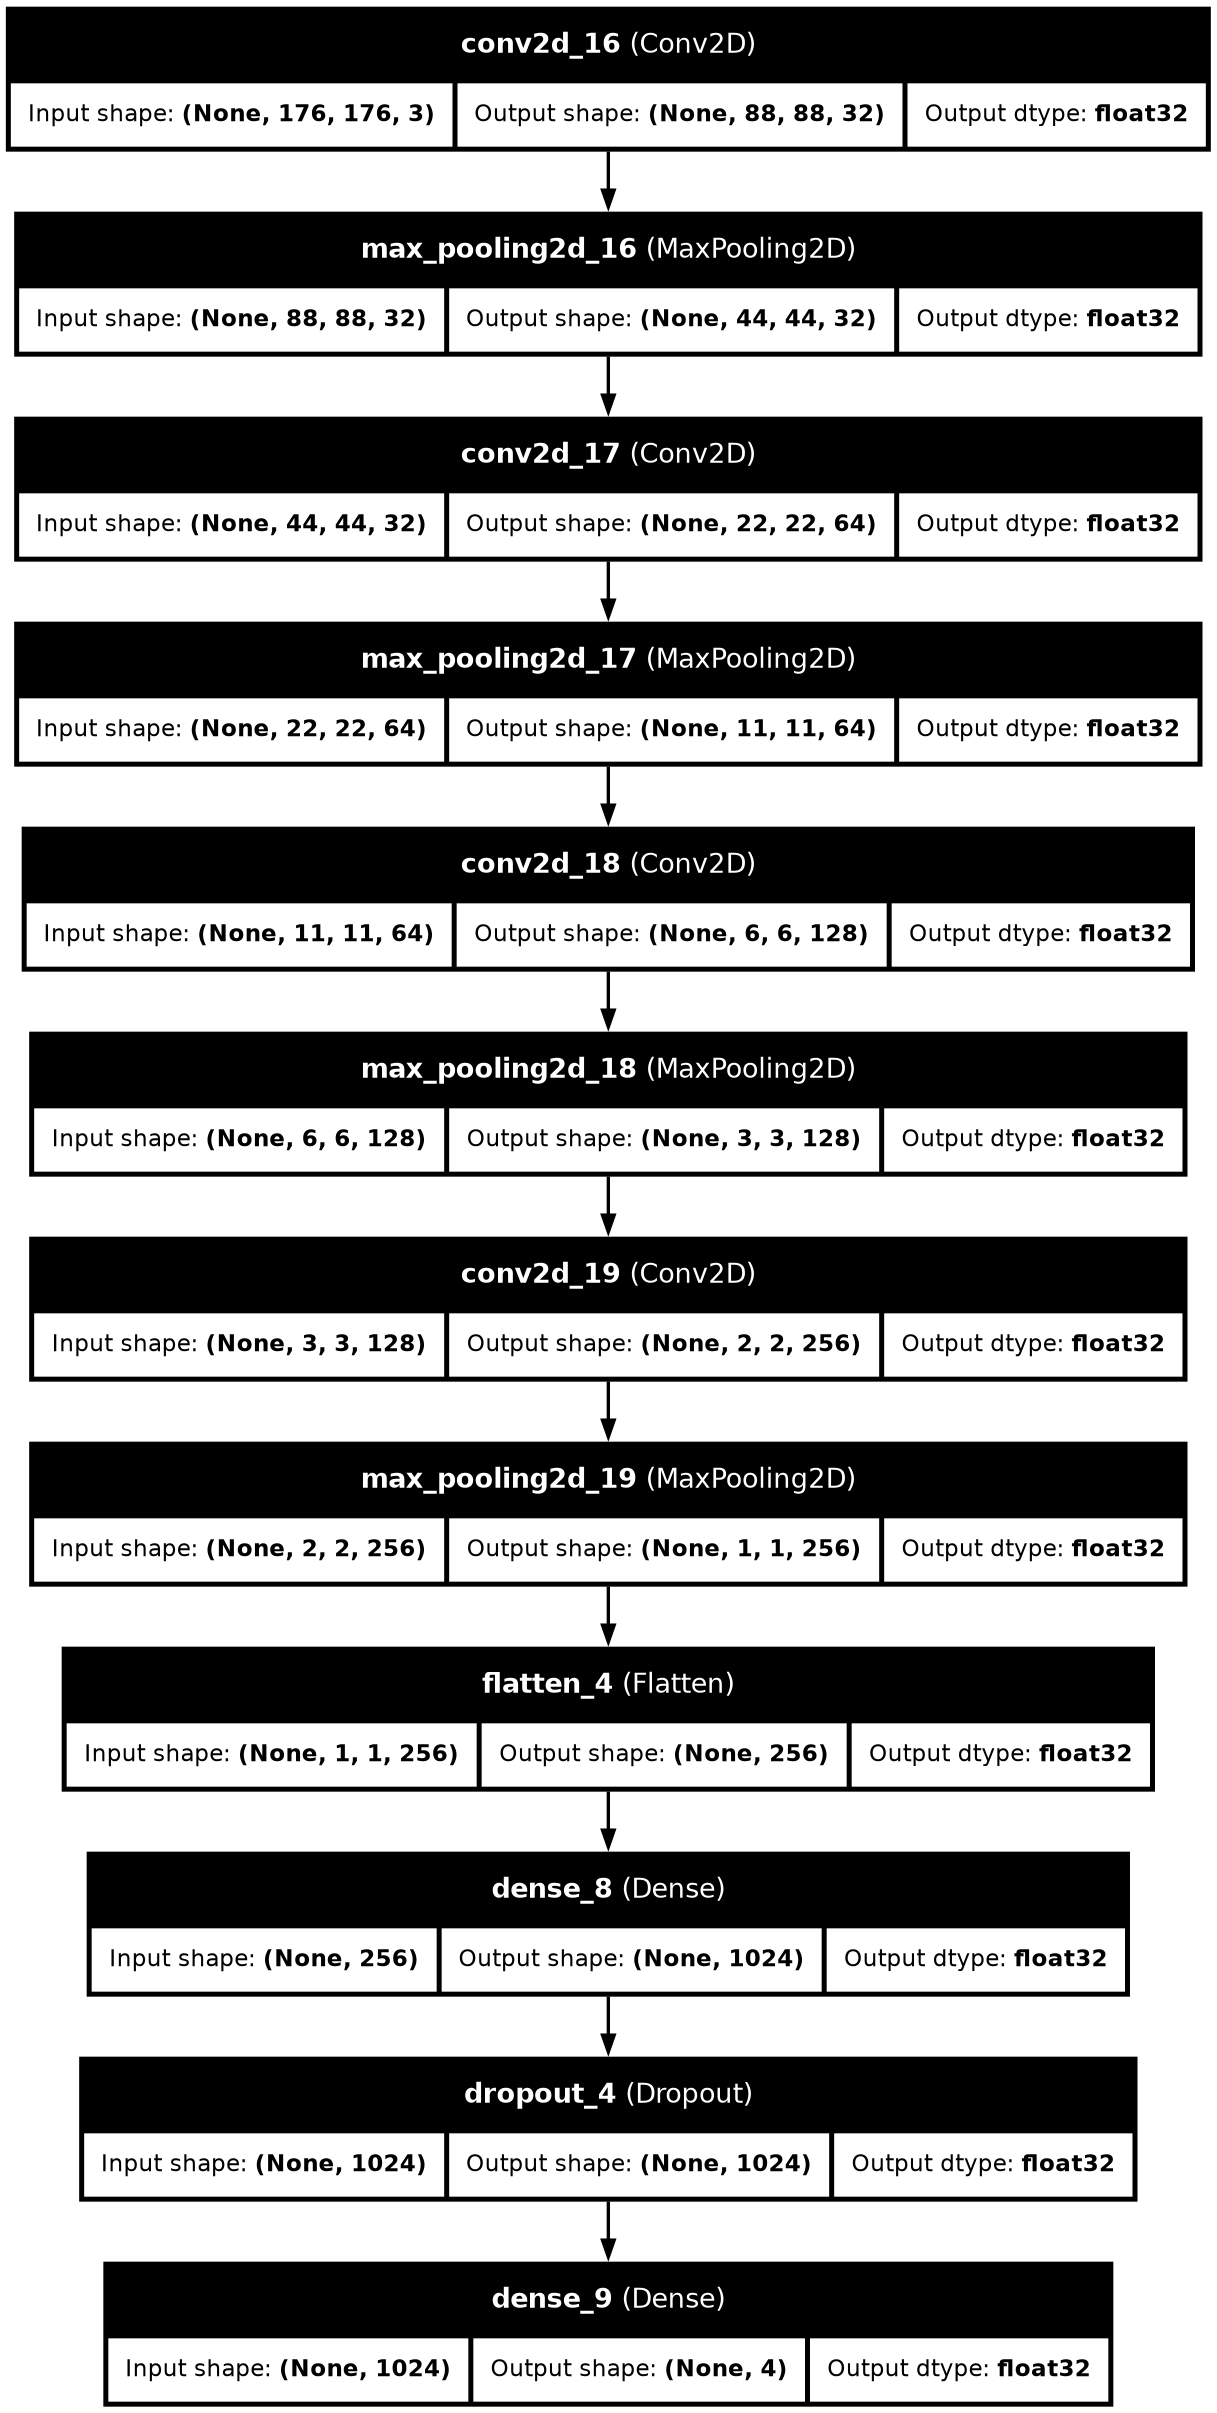

In [38]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [40]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [41]:
checkpoint_cb =ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.4062 - loss: 1.1403 - val_accuracy: 0.6490 - val_loss: 0.6927
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.7228 - loss: 0.5839 - val_accuracy: 0.7573 - val_loss: 0.5322
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.8362 - loss: 0.3887 - val_accuracy: 0.8776 - val_loss: 0.2711
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.8974 - loss: 0.2400 - val_accuracy: 0.8708 - val_loss: 0.2980
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.9229 - loss: 0.1846 - val_accuracy: 0.9135 - val_loss: 0.1922
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.9604 - loss: 0.1044 - val_accuracy: 0.9531 - val_loss: 0.1132
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.9723 - loss: 0.0741 - val_accuracy: 0.9557 - val_loss: 0.1178
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.9777 - loss: 0

In [42]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.543080  0.906384      0.648958  0.692706
1   0.752679  0.530150      0.757292  0.532174
2   0.846094  0.351331      0.877604  0.271114
3   0.897433  0.243078      0.870833  0.298043
4   0.927232  0.174902      0.913542  0.192205
5   0.958371  0.108301      0.953125  0.113189
6   0.971317  0.075629      0.955729  0.117781
7   0.977455  0.062178      0.950521  0.141603
8   0.980692  0.050532      0.942187  0.154572
9   0.984263  0.045021      0.908854  0.333719
10  0.982589  0.050395      0.930208  0.220338
11  0.989955  0.029164      0.973958  0.086561
12  0.985603  0.041541      0.920313  0.229978
13  0.989621  0.031777      0.969271  0.089310
14  0.989397  0.030274      0.972917  0.103847
15  0.990848  0.024199      0.968750  0.091661
16  0.988393  0.031124      0.969792  0.079118
17  0.997991  0.007192      0.969271  0.123484
18  0.989955  0.028608      0.975521  0.076180
19  0.987612  0.033139      0.968750  0.086996
20  0.991741  0.022402      0.967188  0.095562
21  0.991406  0.026194      0.963021  0.126416
22  0.990513  0.025027      0.977604  0.063924
23  0.992746  0.021219      0.974479  0.084598
24  0.996875  0.009151      0.981771  0.062542
25  0.997321  0.010842      0.983854  0.066452
26  0.990067  0.027228      0.955729  0.170171
27  0.991964  0.024321      0.982813  0.061611
28  0.988839  0.032987      0.980208  0.057242
29  0.997210  0.008799      0.983333  0.051875
30  0.997656  0.007322      0.980208  0.087722
31  0.992076  0.025208      0.950000  0.185884
32  0.995982  0.010799      0.986979  0.045497
33  0.995982  0.011799      0.991146  0.026231
34  0.990513  0.029215      0.985417  0.056924
35  0.994866  0.016780      0.984375  0.050904
36  0.997321  0.006621      0.988542  0.041585
37  0.999665  0.001589      0.991667  0.026830
38  0.999442  0.003546      0.968750  0.146030
39  0.984598  0.046985      0.970312  0.117417
40  0.995313  0.014839      0.976562  0.076879
41  0.999665  0.001868      0.987500  0.042166
42  1.000000  0.000055      0.993229  0.036050
43  1.000000  0.000006      0.992188  0.036065

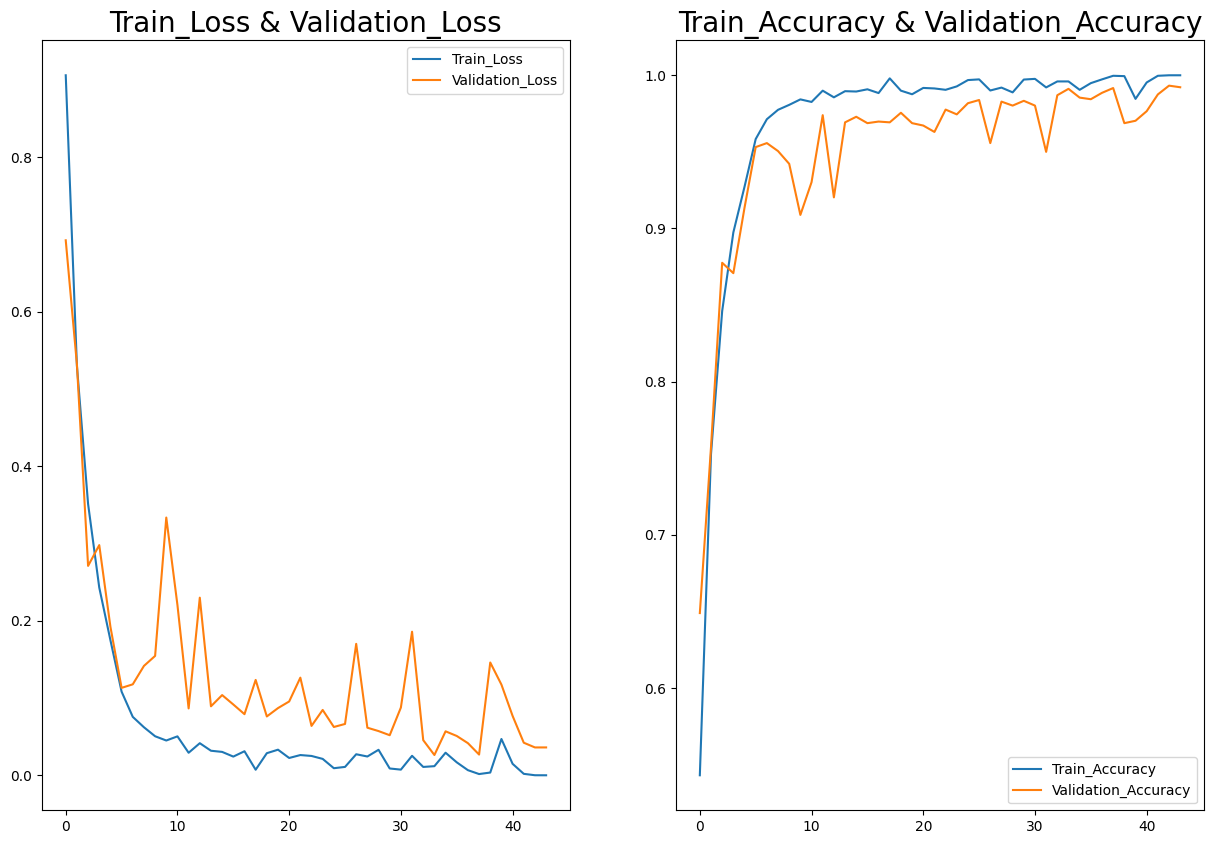

In [43]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [44]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9921 - loss: 0.0471
Test Loss = 0.034877046942710876
Test Accuracy = 0.9937499761581421
